#### importing packages

In [1]:
import os
import sys
os.getcwd()

'c:\\Users\\ebaca\\Desktop\\Phys 417\\Final Project - HEP Tagging'

In [2]:
# importing libraries & making torch.device object for GPU

# neural network packages
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.rnn as rnn_utils

from torch import Tensor
# from torch.nn import Transformer
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

# data packages
import numpy as np
import math
import pandas as pd
# import sklearn.preprocessing as prep
# from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# visual packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tqdm
import warnings

# Create a torch.device object to tell pytorch where to store your tensors: cpu or gpu
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#### analyzing jet distributions

In [3]:
onehots_dict = {
    (1, 0, 0, 0, 0): ['Gluon', 0],
    (0, 1, 0, 0, 0): ['Light Quark', 0],
    (0, 0, 1, 0, 0): ['W Boson', 0],
    (0, 0, 0, 1, 0): ['Z Boson', 0],
    (0, 0, 0, 0, 1): ['Top Quark', 0]
}
# print(list(onehots.values()))

files = shuffle([os.path.join('../../PHYS417_Project/data/'+ f) for f in os.listdir('../../PHYS417_Project/data')])

for i, f in enumerate(files):
    # with np.load('../../PHYS417_Project/data/' + f) as data_load:
    with np.load(f) as data_load:
        y = data_load['y']

        if tuple(y) in onehots_dict:
            onehots_dict[tuple(y)][1] += 1

display(onehots_dict)

{(1, 0, 0, 0, 0): ['Gluon', 3942],
 (0, 1, 0, 0, 0): ['Light Quark', 3835],
 (0, 0, 1, 0, 0): ['W Boson', 4150],
 (0, 0, 0, 1, 0): ['Z Boson', 4053],
 (0, 0, 0, 0, 1): ['Top Quark', 4020]}

#### building architectures

In [4]:
# Define your model architecture
class JetClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout_prob=0.5):
        super(JetClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_prob)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # out = self.dropout(out[:, -1, :])
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# custom PyTorch dataset (for DataLoader)
class JetDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path = self.files[idx]
        with np.load(file_path) as data_load:
            x_load = torch.tensor(data_load['x'], dtype=torch.float32)
            y_load = torch.tensor(data_load['y'], dtype=torch.float32)
        return x_load, y_load

# the collate function lets the model handle variable-length sequences
def collate_fn(batch):
    # sorting batch in descending order of # of constituents
    # batch.sort(key=lambda x: x[0].size(0), reverse=True)   # option to sort by sequence length
    inputs, labels = zip(*batch)
    # adding padding to the sequences
    inputs_padded = pad_sequence(inputs, batch_first=True, padding_value=0)
    # labels_padded = pad_sequence(labels, batch_first=True, padding_value=0)
    labels = torch.stack(labels)  # Ensure labels are stacked without padding
    return inputs_padded, labels

# function to extract numpy arrays from tensors
extractor = lambda x: x.cpu().detach().numpy()

#### preparing data

In [8]:
'''Extracting Files ----------------------------------------------------------'''

print(f'First 70% of files: {len(files[:int(0.7*len(files))])} \nLast 30% of files: {len(files[int(0.7*len(files)):])}')



'''Splitting Files ----------------------------------------------------------'''

# splitting into training/testing sets
train_files = files[:int(0.7*len(files))]
test_files = files[int(0.7*len(files)):]

print(f"{len(train_files)} Training Files  + {len(test_files)} Testing Files  =  {len(files)} Total Files\n")
print(f'First 5 training files: {train_files[:5]} \nFirst 5 testing files: {test_files[:5]}\n')



'''Converting to Dataset Objects --------------------------------------------------------'''

train_dataset = JetDataset(train_files)
test_dataset = JetDataset(test_files)

# train_dataset[event n][input/label][constituent n, property n]
print(f'TrSet (event 0): {train_dataset[0][0].shape} \n{train_dataset[0][0][:1]} \nOnehot vector: {train_dataset[0][1]}\n')
# print(f'TeSet First const. (event 0): \n{test_dataset[0][0][:1]} \nOnehot vector: {test_dataset[0][1]}\n')



'''Creating DataLoaders/Applying Collate Fn (Padding) --------------------------------------------------------'''

class_weights = [1 / count for count in [value[1] for value in onehots_dict.values()]]

trweights = [
    class_weights[torch.argmax(tag).item()] 
        for tag in [train_dataset[i][1] 
                for i in range(len(train_dataset))]
]
trsampler = WeightedRandomSampler(trweights, len(train_dataset), replacement=True)

teweights = [
    class_weights[torch.argmax(tag).item()] 
        for tag in [test_dataset[i][1] 
                for i in range(len(test_dataset))]
]
tesampler = WeightedRandomSampler(teweights, len(test_dataset), replacement=True)

print(len(trweights), len(teweights))

# make datasets into DataLoader objects and apply collate_fn
train_loader = DataLoader(train_dataset, batch_size=13, shuffle=False, collate_fn=collate_fn, sampler=trsampler)
test_loader = DataLoader(test_dataset, batch_size=13, shuffle=False, collate_fn=collate_fn, sampler=tesampler)


# # inspecting how padding went in collate_fn
# # loader[input or label][batch n][event e][constituent n, property n]
# n=0
# for nbatch_x, nbatch_y in train_loader: # loops through n batches or loader[input/label][batch n]
#     # inputs = array containing each events' data['x'] in the batch
#     # labels = array containing each events' data['y'] in the batch
#     print(f'\n --------------------------------------- [Batch {n}] --------------------------------------- \n')
#     print(f'Input shape: {nbatch_x.shape}, Label shape: {nbatch_y.shape}\n') # general shape of the batch

#     e=0
#     # printing first 5 events in the batch
#     for (properties, tag) in zip(nbatch_x[:2], nbatch_y[:2]):
#         # printing the first 5 constituents/properties
#         print(f'--Event {n}.{e}--',
#               f'\n{extractor(properties[:1])} \n{extractor(properties[-1:])}, \nTag: {extractor(tag)}\n')
#         e+=1
    
#     # to stop after some number of events
#     n+=1
#     if n == 1: 
#         break

First 70% of files: 14000 
Last 30% of files: 6000
14000 Training Files  + 6000 Testing Files  =  20000 Total Files

First 5 training files: ['../../PHYS417_Project/data/event_0165052.npz', '../../PHYS417_Project/data/event_0133623.npz', '../../PHYS417_Project/data/event_0464926.npz', '../../PHYS417_Project/data/event_0701446.npz', '../../PHYS417_Project/data/event_0846361.npz'] 
First 5 testing files: ['../../PHYS417_Project/data/event_0161314.npz', '../../PHYS417_Project/data/event_0530506.npz', '../../PHYS417_Project/data/event_0621990.npz', '../../PHYS417_Project/data/event_0635608.npz', '../../PHYS417_Project/data/event_0602021.npz']

TrSet (event 0): torch.Size([62, 5]) 
tensor([[0.1297, -0.0000, 0.0000, 0.1292, 0.0070]]) 
Onehot vector: tensor([1., 0., 0., 0., 0.])

14000 6000


#### initializing & training

In [9]:
'''
Initializing Model & Hyperparameters ----------------------------------------------------------
'''

# Initialize the model
input_size = 5  # Number of features for each constituent
hidden_size = 128
num_layers = 3
num_classes = 5  # Number of categories for jet classification

model = JetClassifier(input_size, hidden_size, num_layers, num_classes).to(DEVICE)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss().to(DEVICE)  # Binary Cross Entropy Loss for multi-label classification
# criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights).to(DEVICE)) # includes softmax layer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

In [10]:
''' 
Training -------------------------------------------------------------------
'''
# [batch size][max sequence length][input size/number of features]

num_epochs = 20
losses = []

for epoch in tqdm.trange(num_epochs):
    model.train()
    
    loss_ct = 0
    for events, tags in train_loader:
        events, onehots = events.to(DEVICE), tags.to(DEVICE)
        # tags = torch.argmax(onehots, dim=1) # Convert one-hot encoded labels to single integer labels

        optimizer.zero_grad()
        outputs = model(events)

        # loss = criterion(outputs, tags)
        loss = criterion(outputs, onehots)
        loss.backward()
        optimizer.step()

        loss_ct += loss.item()

    scheduler.step()

    avg_loss = loss_ct / len(train_loader)
    losses.append(avg_loss)

    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}')
    # print(f'Inputs: {events.shape}  \nOnehot: {extractor(onehots[:1][0])}  ArgMax Index: {extractor(onehots[:1].argmax(dim=1))}')
    softmax = nn.Softmax(dim=1)
    probabilities = softmax(outputs)
    # print(f'Outputs: {extractor(outputs[:1][0])}')
    # print(f'Probabilities: {extractor(probabilities[:1][0])}')
    # print('\n')

100%|██████████| 20/20 [04:50<00:00, 14.50s/it]


Text(0.5, 1.0, 'Training Losses')

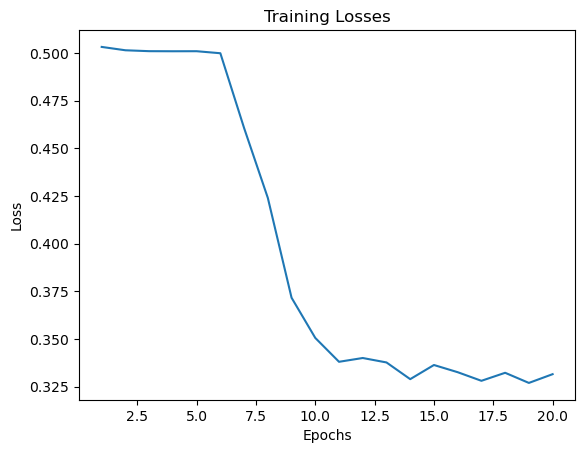

In [11]:
plt.figure()
plt.plot(range(1, num_epochs+1), losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')

#### testing

In [12]:
''' 
Evaluation -------------------------------------------------------------------

[batch size][max sequence length][input size/number of features]
'''
display(onehots_dict)
print(f'[Sample Overview] \n{len(train_files)} Training Files \n{len(test_files)} Testing Files \n{len(files)} Total Files \n')

def evaluate_model(model, test_loader):
    warnings.filterwarnings('ignore')

    model.eval()
    correct = 0
    total = 0
    label_list = []
    prediction_list = []
    with torch.no_grad():
        for sequences, labels in test_loader:
            labels = torch.argmax(labels, dim=1).to(DEVICE)
            outputs = model(sequences.to(DEVICE))
            predicted = torch.argmax(outputs, dim=1).to(DEVICE)

            # print(predicted)
            # print(labels, '\n')
            label_list.extend(labels.cpu().numpy())
            prediction_list.extend(predicted.cpu().numpy())

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    print(f"Accuracy: {accuracy:.4f}")

    cm = confusion_matrix(label_list, prediction_list)
    precision = precision_score(label_list, prediction_list, average='weighted')
    recall = recall_score(label_list, prediction_list, average='weighted')
    f1 = f1_score(label_list, prediction_list, average='weighted')
    
    print(f'Confusion Matrix:\n{cm}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')

evaluate_model(model, test_loader)

{(1, 0, 0, 0, 0): ['Gluon', 3942],
 (0, 1, 0, 0, 0): ['Light Quark', 3835],
 (0, 0, 1, 0, 0): ['W Boson', 4150],
 (0, 0, 0, 1, 0): ['Z Boson', 4053],
 (0, 0, 0, 0, 1): ['Top Quark', 4020]}

[Sample Overview] 
14000 Training Files 
6000 Testing Files 
20000 Total Files 

Accuracy: 0.6143
Confusion Matrix:
[[802 134  52  38 176]
 [209 717 156  54  87]
 [ 60  84 739 309   8]
 [ 80  66 464 519  47]
 [ 96   7  71 116 909]]
Precision: 0.6198
Recall: 0.6143
F1 Score: 0.6142
